<a href="https://colab.research.google.com/github/PANKAJ-SADHUKHAN/learn-git/blob/main/U_net_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import imageio
from PIL import Image
import numpy as np

## Downloading Dataset

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteJ8CLA6/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteJ8CLA6/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


## Informatio about dataset

In [4]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmp00e1r0zdtfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

# Resize the images and masks to 128x128



In [5]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

   return input_image, input_mask

# Create a function to augment the dataset by flipping them horizontally

In [6]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

# Create a function to normalize the dataset by scaling the images to the range of [-1,-1] and decreasing the image mask by 1

In [7]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

# Create two functions to preprocess the training and test datasets with a slight difference between the two – we only perform image augmentation on the training dataset.

In [8]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

#  build an input pipeline with tf.data by using the map() function

In [9]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

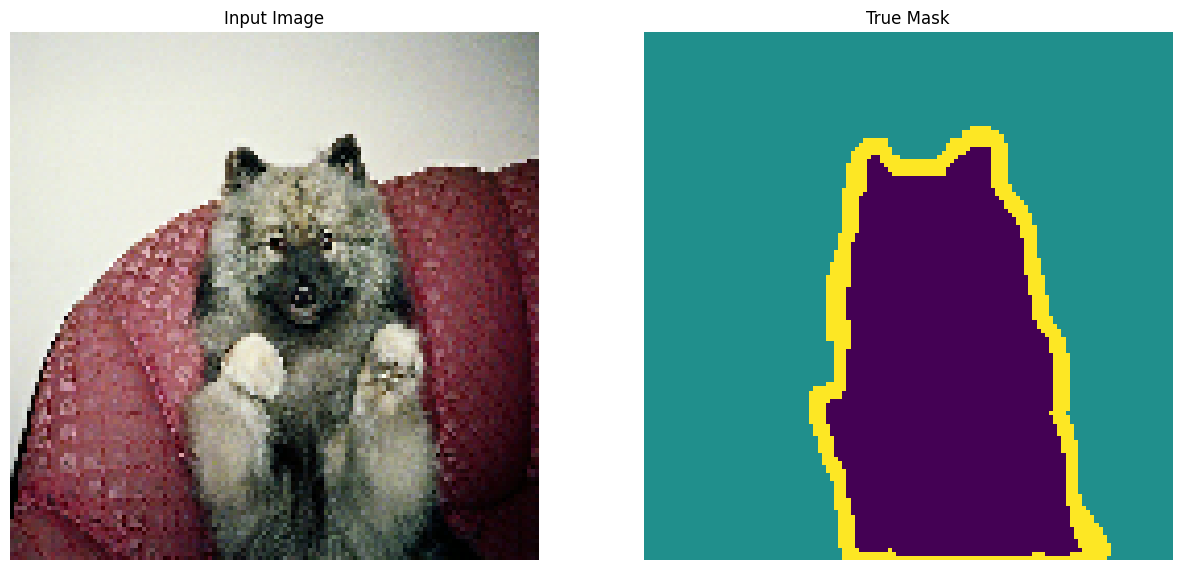

In [11]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

# Define U-net Model Architecture

# U-net model has U shapped curve with an encoder, decoder, and the skip connections b/w them

# 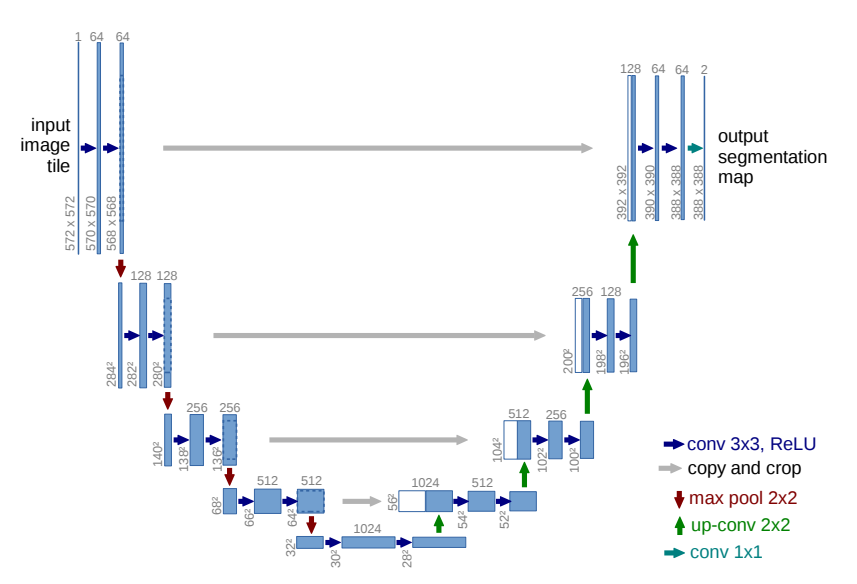

 # create a function double_conv_block with layers Conv2D-ReLU-Conv2D-ReLU, which we will use in both the encoder (or the contracting path) and the bottleneck of the U-Net.

In [12]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

# define a downsample_block function for downsampling or feature extraction to be used in the encoder.

In [13]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

# we define an upsampling function upsample_block for the decoder (or expanding path) of the U-Net

In [14]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

# we create a create_unet_model function, specify the inputs, encoder layers, bottleneck, decoder layers, and finally the output layer with Conv2D with activation of softmax. Note the input image shape is 128x128x3. The output has three channels corresponding to the three classes that the model will classify each pixel for: background, foreground object, and object outline

In [15]:
def create_unet_model():
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation="softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model



In [16]:
unet_model = create_unet_model()

#Compile and Train U-Net

In [17]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

# We train the unet_model by calling model.fit() and training it for 5 epochs

In [29]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=validation_batches)

Epoch 1/20
57/57 [==============================] - 59s 1s/step - loss: 0.4896 - accuracy: 0.8088 - val_loss: 0.4966 - val_accuracy: 0.8116
Epoch 2/20
57/57 [==============================] - 57s 1s/step - loss: 0.4733 - accuracy: 0.8153 - val_loss: 0.4413 - val_accuracy: 0.8307
Epoch 3/20
57/57 [==============================] - 58s 1s/step - loss: 0.4424 - accuracy: 0.8297 - val_loss: 0.4524 - val_accuracy: 0.8277
Epoch 4/20
57/57 [==============================] - 58s 1s/step - loss: 0.4081 - accuracy: 0.8425 - val_loss: 0.3876 - val_accuracy: 0.8493
Epoch 5/20
57/57 [==============================] - 59s 1s/step - loss: 0.3966 - accuracy: 0.8471 - val_loss: 0.3912 - val_accuracy: 0.8500
Epoch 6/20
57/57 [==============================] - 60s 1s/step - loss: 0.3759 - accuracy: 0.8552 - val_loss: 0.3644 - val_accuracy: 0.8602
Epoch 7/20
57/57 [==============================] - 60s 1s/step - loss: 0.3568 - accuracy: 0.8627 - val_loss: 0.3793 - val_accuracy: 0.8567
Epoch 8/20
57/57 [==

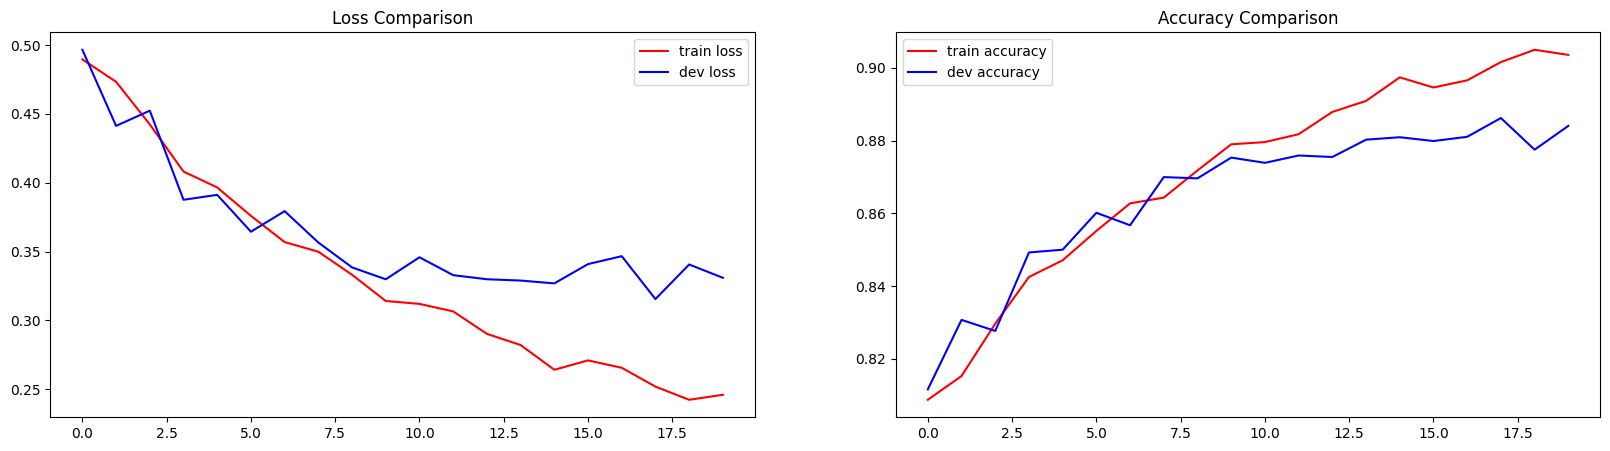

In [30]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(model_history.history["loss"], color='r', label = 'train loss')
axis[0].plot(model_history.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(model_history.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(model_history.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()


In [31]:
unet_model.evaluate(validation_batches)

47/47 [==============================] - 13s 265ms/step - loss: 0.3357 - accuracy: 0.8820


[0.33567532896995544, 0.8820043802261353]

In [32]:
def split_features_labels(features, labels):
    return features, labels

# Map the function to your validation batches
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
validation_batches = validation_batches.map(split_features_labels)

# Now you can iterate over the validation batches and extract X_pred and y_pred
X_pred_list = []
y_pred_list = []
for X_batch, y_batch in validation_batches:
    X_pred_list.append(X_batch)
    y_pred_list.append(y_batch)

# Convert the lists to numpy arrays if needed
X_pred = np.concatenate(X_pred_list)
y_pred = np.concatenate(y_pred_list)

In [33]:
def VisualizeResults(index):
    img = X_pred[index]
    img = img[np.newaxis, ...]
    pred_y = unet_model.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_pred[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_pred[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

1/1 [==============================] - 0s 29ms/step


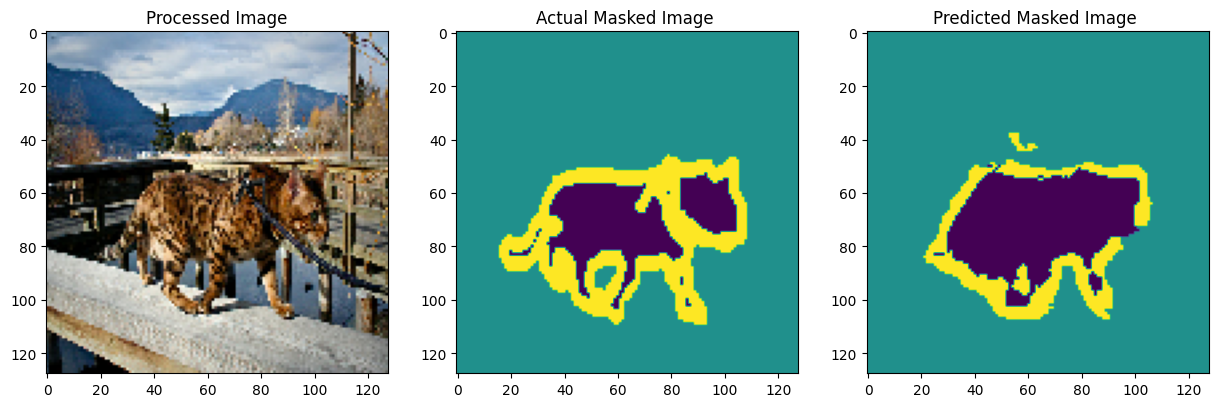

In [37]:
index = 700
VisualizeResults(index)